# Libraries and Dependencies

In [5]:
import os
import random
from concurrent.futures import ThreadPoolExecutor

import cv2 
import numpy as np
import pyvips
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm

In [42]:
def apply_gamma_correction(img, gamma):
  lookUpTable = np.empty((1,256), np.uint8)
  for i in range(256):
      lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
  return cv.LUT(img, lookUpTable)

In [3]:
def calculate_score(area, circularity, white_percentage):
    # Normalize each metric to the range [0, 1]
    area_score = min(max((area - 100) / (1000 - 100), 0), 1)  # Normalize area between 100 and 1000
    circularity_score = min(max((circularity - 0.48) / (1 - 0.48), 0), 1)  # Normalize circularity between 0.48 and 1
    white_percentage_score = min(max((white_percentage - 0.05) / (1 - 0.05), 0), 1)  # Normalize white percentage between 0.05 and 1

    # Weighted average of the metrics with more emphasis on circularity
    score = 0.25 * area_score + 0.5 * circularity_score + 0.25 * white_percentage_score
    return score

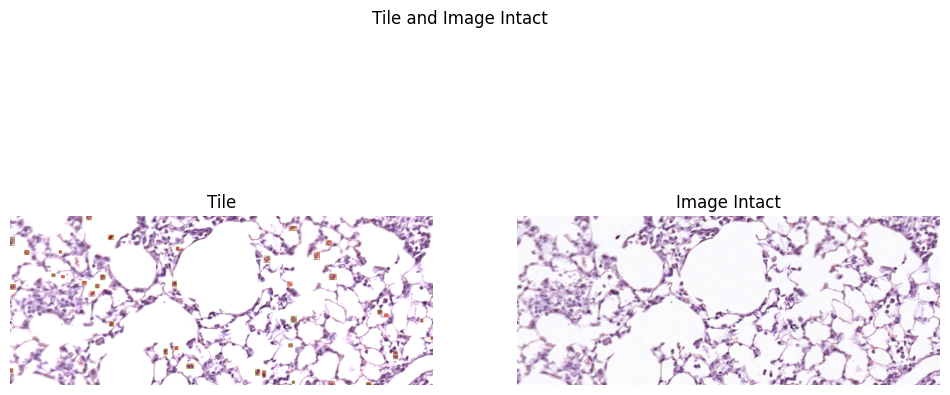

In [6]:
img_name = 'tile_25000_52000.jpg'
file_name = os.path.expanduser('~/Documents/Code/Lung_Injury/Tiles_1000_2500_1/' + img_name)
out_dir = os.path.expanduser('~/Documents/Code/Lung_Injury/' + img_name)


tile = cv2.imread(file_name)
image_intact = tile.copy()


tile[tile > 220] = 255

# Step 1: Convert to grayscale
gray_tile = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)

# Step 2: Thresholding using Otsu's method
_, thresh = cv2.threshold(gray_tile, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 3: Find the external contours (outer boundaries)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask for the outer regions
mask = np.zeros_like(gray_tile)

# Draw the external contours on the mask (fill in the contours)
cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

# Step 4: Invert the mask to focus on internal regions
internal_mask = cv2.bitwise_not(mask)

# Step 5: Apply the internal mask to the original thresholded image to isolate internal regions
internal_only = cv2.bitwise_and(thresh, thresh, mask=internal_mask)

# Step 6: Detect internal contours in the isolated regions
internal_contours, _ = cv2.findContours(internal_only, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the original contours in green and internal contours in blue for better visualization
# cv2.drawContours(tile, contours, -1, (0, 255, 0), 2)  # Draw outer boundaries in green
# cv2.drawContours(tile, internal_contours, -1, (255, 0, 0), 2)  # Draw internal contoursW in blue    return score

for contour in contours:
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if perimeter == 0:
        continue

    # Calculate circularity
    circularity = 4 * np.pi * (area / (perimeter * perimeter))

    # Filter by area and circularity
    if 100 < area < 1000 and 0.48 < circularity < 1:
        # Get bounding box for the detected cell
        x, y, w, h = cv2.boundingRect(contour)
        
        # Define padding as a function of the object's area
        k = 0.5  # Adjust this value to control the padding relative to the area
        padding = int(k * np.sqrt(area))  # Calculate padding based on the object's area

        # Calculate the center of the bounding box
        center_x = x + w // 2
        center_y = y + h // 2

        # Use the calculated padding as the radius for the neighborhood
        radius = padding

        # Ensure the circular region is within bounds of the image
        radius = min(radius, center_x, center_y, tile.shape[1] - center_x, tile.shape[0] - center_y)

        # Extract the neighborhood region around the cell (using a mask)
        neighborhood_mask = np.zeros_like(thresh, dtype=np.uint8)
        cv2.circle(neighborhood_mask, (center_x, center_y), radius, 255, thickness=-1)

        # Use the mask to isolate the circular neighborhood region
        neighborhood = cv2.bitwise_and(thresh, thresh, mask=neighborhood_mask)

        # Draw a red circle around the neighborhood coverage
        cv2.circle(tile, (center_x, center_y), radius, (0, 0, 255), 2)  # Red circle for neighborhood coverage

        # Calculate the percentage of white pixels in the neighborhood
        total_pixels = cv2.countNonZero(neighborhood_mask)
        white_pixels = cv2.countNonZero(neighborhood)
        white_percentage = white_pixels / total_pixels

        # Check if the majority of the neighborhood is white (> threshold)
        if white_percentage > 0.05:  # You can adjust this threshold as needed
            # Calculate the score based on area, circularity, and white percentage
            score = calculate_score(area, circularity, white_percentage)

            # Determine the color based on the score (0 - red, 1 - green)
            red = int(255 * (1 - score))
            green = int(255 * score)
            color = (0, green, red)  # Color goes from red to green

            # Draw the bounding box on the original tile image with the calculated color
            cv2.rectangle(tile, (x, y), (x + w, y + h), color, 2)

# Step 5: Display the improved tile image with bounding boxes
cv2.imwrite(out_dir, tile)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(tile, cv2.COLOR_BGR2RGB))
axes[0].set_title("Tile")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(image_intact, cv2.COLOR_BGR2RGB))
axes[1].set_title("Image Intact")
axes[1].axis('off')

plt.suptitle("Tile and Image Intact")
plt.show()